In [1]:
#from numba import jit
import numpy as np
import scipy.constants as constants
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [2]:
class DiscretePlaneWave():
    '''
    Class to implement the discrete plane wave (DPW) formulation as described in
    Tan, T.; Potter, M. (2010). 
    FDTD Discrete Planewave (FDTD-DPW) Formulation for a Perfectly Matched Source in TFSF Simulations. ,
    58(8), 0–2648. doi:10.1109/tap.2010.2050446 
    __________________________
    
    Instance variables:
    --------------------------
        m, int array           : stores the integer mappings, m_x, m_y, m_z which determine the rational angles
                                 last element stores max(m_x, m_y, m_z)
        dimensions, int        : stores the number of dimensions in which the simulation is run (2D or 3D)
        time_dimension, int    : stores the time length over which the simulation is run
        E_fileds, double array : stores the electric flieds associated with the 1D DPW
        H_fields, double array : stores the magnetic fields associated with the 1D DPW
    '''
    
    
    def __init__(self, time_dimension, dimensions):     
        '''
        Defines the instance variables of class DiscretePlaneWave()
        __________________________

        Input parameters:
        --------------------------
            time_dimension, int : local variable to store the time length over which the simulation is run 
            dimensions, int     : local variable to store the number of dimensions in which the simulation is run
        '''
        self.m = np.zeros(dimensions+1)      #+1 to store the max(m_x, m_y, m_z)
        self.dimensions = dimensions
        self.time_dimension = time_dimension
        self.E_fields = []   
        self.H_fields = []
        
    def initializeGrid(self, length_dimension, dl, dt):
        '''
        Method to initialize the one dimensions grids for the DPW
        __________________________

        Input parameters:
        --------------------------
            length_dimension, int : stores the spatial length of the ggrids for the DPW
            dl, double            : stores the spatial seperation between two adjacent elements of the DPW array
            dt, double            : stores the temporal separation between two adjacent rows of the DPW array
        __________________________

        Returns:
        --------------------------
            E_fields, double array :       stores the electric field values for the DPW
                                           first index denotes the spatial dimension
                                           second index denotes the spatial position (grid cell position index)
                                           thid index denotes time (grid cell time index)
            H_fields, double array :       stores the magnetic field values for the DPW
                                           first index denotes the spatial dimension
                                           second index denotes the spatial position (grid cell position index)
                                           thid index denotes time (grid cell time index)
            E_coefficients, double array : stores the coefficients of the fields in the equation to update electric fields
            H_coefficients, double array : stores the coefficients of the fields in the equation to update magnetic fields

        '''
        E_fields = np.zeros((self.dimensions, length_dimension, self.time_dimension))
        H_fields = np.zeros((self.dimensions, length_dimension, self.time_dimension))
    
        E_coefficients = np.zeros(9)     #coefficients in the update equations of the electric field
        H_coefficients = np.zeros(9)     #coefficients in the update equations of the magnetic field
        impedance = constants.c*constants.mu_0   #calculate the impedance of free space 
    
        for i in range(self.dimensions): #loop to calculate the coefficients for each dimension
            E_coefficients[3*i] = 1.0
            E_coefficients[3*i+1] = dt/(constants.epsilon_0*dl[(i+1)%self.dimensions])
            E_coefficients[3*i+2] = dt/(constants.epsilon_0*dl[(i+2)%self.dimensions])        
            
            H_coefficients[3*i] = 1.0
            H_coefficients[3*i+1] = dt/(constants.mu_0*dl[(i+2)%self.dimensions])
            H_coefficients[3*i+2] = dt/(constants.mu_0*dl[(i+1)%self.dimensions])
        
        return E_fields, H_fields, E_coefficients, H_coefficients
    
    def updateMagneticFields(self, n, H_coefficients, H_fields, E_fields, time):
        '''
        Method to update the magnetic fields for the next time step using
        Equation 8 of DOI: 10.1109/LAWP.2009.2016851
        __________________________

        Input parameters:
        --------------------------
            n , int                      : stores the spatial length of the DPW array so that each length grid cell is updated when the method updateMagneticFields() is called
            H_coefficients, double array : stores the coefficients of the fields in the update equation for the magnetic field
            H_fields, double array       : stores the magnetic fields of the DPW till temporal index time
            E_fields, double array       : stores the electric fields of the DPW till temporal index time
            time, int                    : time index storing the current axis number which would be updated for the H_fields
        __________________________

        Returns:
        --------------------------
            H_fields, double array       : magnetic field array with the axis entry for the current time added

        '''
        for i in range(self.dimensions):  #loop to update each component of the magnetic field
            for j in range(self.m[-1], n-self.m[-1]):  #loop to update the magnetic field at each spatial index
                H_fields[i, j, time] = H_coefficients[3*i] * H_fields[i, j, time-1] + H_coefficients[3*i+1] * (
                    E_fields[(i+1)%self.dimensions, j+self.m[(i+2)%self.dimensions], time-1] 
                    - E_fields[(i+1)%self.dimensions, j, time-1]) \
                - H_coefficients[3*i+2] * (
                    E_fields[(i+2)%self.dimensions, j+self.m[(i+1)%self.dimensions], time-1] 
                    - E_fields[(i+2)%self.dimensions, j, time-1])     #equation 8 of Tan, Potter paper
        return H_fields
    
    def updateElectricFields(self, n, E_coefficients, H_fields, E_fields, time):
        '''
        Method to update the electric fields for the next time step using
        Equation 9 of DOI: 10.1109/LAWP.2009.2016851
        __________________________

        Input parameters:
        --------------------------
            n , int                      : stores the spatial length of the DPW array so that each length grid cell is updated when the method updateMagneticFields() is called
            E_coefficients, double array : stores the coefficients of the fields in the update equation for the electric field
            H_fields, double array       : stores the magnetic fields of the DPW till temporal index time
            E_fields, double array       : stores the electric fields of the DPW till temporal index time
            time, int                    : time index storing the current axis number which would be updated for the H_fields
        __________________________

        Returns:
        --------------------------
            E_fields, double array       : electric field array with the axis entry for the current time added

        '''
        for i in range (self.dimensions):  #loop to update each component of the electric field
            for j in range(self.m[-1], n-self.m[-1]):   #loop to update the electric field at each spatial index 
                E_fields[i, j, time] = E_coefficients[3*i] * E_fields[i, j, time-1] + E_coefficients[3*i+1] * (
                    H_fields[(i+2)%self.dimensions, j, time] 
                    - H_fields[(i+2)%self.dimensions, j-self.m[(i+1)%self.dimensions], time]) \
                - E_coefficients[3*i+2] * ( 
                    H_fields[(i+1)%self.dimensions, j, time] 
                    - H_fields[(i+1)%self.dimensions, j-self.m[(i+2)%self.dimensions], time])  #equation 9 of Tan, Potter paper
        return E_fields
    
    def getSource(self, time, ppw):
        '''
        Method to get the magnitude of the source field in the direction perpendicular to the propagation of the plane wave
        __________________________

        Input parameters:
        --------------------------
            time, float : time at which the magnitude of the source is calculated
            ppw, int    : points per wavelength for the wave source

        __________________________

        Returns:
        --------------------------
            sourceMagnitude, double array : magnitude of the source for the requested indices at the current time
        '''
        sourceMagnitude = 0
        if time >= 0: 
            arg = np.pi*((time) / ppw - 1.0)
            arg = arg * arg
            sourceMagnitude = (1.0-2.0*arg)*np.exp(-arg)  # define a Ricker wave source
        return sourceMagnitude
    
    def getProjections(self, psi):
        '''
        Method to get the projects of the source along the different Cartesian axes
        __________________________

        Input parameters:
        --------------------------
            psi, float : polarization angle of the incident plane wave (in radians)

        __________________________

        Returns:
        --------------------------
            p_e, double array : projection vectors for the electric field to assign the electric field components appropriately
            p_h, double array : projection vectors for the magnetic field to assign the magnetic field components appropriately
            p, double array   : projection vectors for the direction cosines
        '''
        if self.m[0] == 0:   #phi=90 degrees, tackled separately
            phi = np.pi/2
        else:
            phi = np.arctan(self.m[1]/self.m[0])    
        if self.m[2] == 0:   #theta=90 degrees, tackled separately
            theta = np.pi/2
        else:
            theta = np.arctan(np.sqrt(self.m[0]**2+self.m[1]**2)/self.m[2])
        p_e = np.array([np.cos(psi)*np.sin(phi)-np.sin(psi)*np.cos(theta)*np.cos(phi),                     
                       -np.cos(psi)*np.cos(phi)-np.sin(psi)*np.cos(theta)*np.sin(phi),
                        np.sin(psi)*np.sin(theta)])   #electric field projection vectors
        p_h = np.array([np.sin(psi)*np.sin(phi)+np.cos(psi)*np.cos(theta)*np.cos(phi),
                       -np.sin(psi)*np.cos(phi)+np.cos(psi)*np.cos(theta)*np.sin(phi),
                       -np.cos(psi)*np.sin(theta)])   #magnetic field projection vectors
        p = np.array([np.sin(theta)*np.cos(phi),      #direction cosines
                  np.sin(theta)*np.sin(phi),
                  np.cos(theta)])                     
    
        return p_e, p_h, p 
    
    def generatePlaneWave(self, projections_e, projections_h, H, E, C, D, d, length, dt):
        '''
        Method to implement the time stepping loop of the FDTD simulation
        __________________________

        Input parameters:
        --------------------------
            p_e, double array : projection vectors for the electric field to assign the electric field components appropriately
            p_h, double array : projection vectors for the magnetic field to assign the magnetic field components appropriately
            H, double array   : stores the magnetic field for the DPW over time and space indices
            E, double array   : stores the electric field for the DPW over time and space indices
            C, double array   : stores the coefficients of the fields for the update equation of the electric fields
            D, double array   : stores the coefficients of the fields for the update equation of the magnetic fields
            d, double array   : stores the projection of the wave vector along the different axes
            length, int       : stores the length of the one dimensional arrays storing the fields for the DPW

        __________________________

        Returns:
        --------------------------
            E, double array   : the electric field for the DPW as it evolves over time and space indices
            H, double array   : the magnetic field for the DPW as it evolves over time and space indices

        '''
        real_time = 0   # initialize the real time to zero
        for t in range(1, self.time_dimension-1):              #time stepping loop to generate the DPW as it evolves with time
            for r in range(self.m[-1]):                        #loop to assign the source values of magnetic field to the first few gridpoints
                H[0, r, t] = projections_h[0]*self.getSource(real_time - (r+(self.m[1]+self.m[2])*0.5)*d[-1]/constants.c, ppw)
                H[1, r, t] = projections_h[1]*self.getSource(real_time - (r+(self.m[0]+self.m[2])*0.5)*d[-1]/constants.c, ppw)
                H[2, r, t] = projections_h[2]*self.getSource(real_time - (r+(self.m[0]+self.m[1])*0.5)*d[-1]/constants.c, ppw)

            H = self.updateMagneticFields(length, D, H, E, t)  #update the magnetic fields in the rest of the DPW grid

            real_time += 0.5*dt  #take a half time step because the magnetic field and electric field grids are staggered in time      

            for r in range(self.m[-1]):  #loop to assign the source values of electric field to the first few gridpoints
                E[0, r, t] = projections_e[0]*self.getSource(real_time - (r+self.m[0]*0.5)*d[-1]/constants.c, ppw)
                E[1, r, t] = projections_e[1]*self.getSource(real_time - (r+self.m[1]*0.5)*d[-1]/constants.c, ppw)
                E[2, r, t] = projections_e[2]*self.getSource(real_time - (r+self.m[2]*0.5)*d[-1]/constants.c, ppw)

            E = self.updateElectricFields(length, C, H, E, t)   #update the electric fields in the rest of the DPW grid

            real_time += 0.5*dt  #take a half time step because the magnetic field and electric field grids are staggered in time
        return E, H
    
    def runDiscretePlaneWave(self, psi, phi, Delta_phi, theta, Delta_theta, number, dx, dy, dz, dt):
        '''
        Method to create a DPW, assign memory to the grids and get field values at different time and space indices
        __________________________

        Input parameters:
        --------------------------
            psi, float         : polarization angle of the incident plane wave (in radians)
            phi, float         : azimuthal angle of the incident plane wave (in radians)
            Delta_phi, float   : permissible error in the rational angle approximation to phi (in radians)
            theta, float       : polar angle of the incident plane wave (in radians)
            Delta_theta, float : permissible error in the rational angle approximation to theta (in radians)
            number, int        : number of cells in the 3D FDTD simulation
            dx, double         : separation between adjacent cells in the x direction
            dy, double         : separation between adjacent cells in the y direction
            dz, double         : separation between adjacent cells in the z direction
            dt, double         : time step for the FDTD simulation
        __________________________

        Returns:
        --------------------------
            E_fields, double array   : the electric field for the DPW as it evolves over time and space indices
            H_fields, double array   : the magnetic field for the DPW as it evolves over time and space indices
            C, double array          : stores the coefficients of the fields for the update equation of the electric fields
            D, double array          : stores the coefficients of the fields for the update equation of the magnetic fields

        '''
        self.m[:-1] = getIntegerForAngles(phi, Delta_phi, theta, Delta_theta,
                                          np.array([dx, dy, dz]))   #get the integers for the nearest rational angle
        self.m[-1] = np.amax(np.abs(self.m))                        #store max(m_x, m_y, m_z) in the last element of the array
        length = int(2*np.sum(self.m[:-1])*number)                  #set an appropriate length fo the one dimensional arrays
        #the 1D grid has no ABC to terminate it, sufficiently long array prevents reflections from the back 
        self.m = np.abs(self.m.astype(np.int64, copy=False))        #typecast to positive integers
        # Projections for field components
        projections_e, projections_h, P = self.getProjections(psi)  #get the projection vertors for different fields
        projections_h = projections_h / np.sqrt(constants.mu_0/constants.epsilon_0) #scale the projection vector for the mangetic field
        
        if self.m[0] == 0:       #calculate dr that is needed for sourcing the 1D array
            if self.m[1] == 0:
                if self.m[2] == 0:
                    raise ValueError("not all M values can be zero")
                else:
                    dr = P[2]*dz/self.m[2]
            else:
                dr = P[1]*dy/self.m[1]
        else:
            dr = P[0]*dx/self.m[0]

        d = np.array([dx, dy, dz, dr])
        
        E, H, C, D = self.initializeGrid(length, d, dt)  #initialize the one dimensional arrays and coefficients
        self.E_fields, self.H_fields = self.generatePlaneWave(projections_e, projections_h, H, E, C, D, d, length, dt)
        #get the DPW fields as it evolves with time
        
        return self.E_fields, self.H_fields, C, D       

In [3]:
def getPhi(required_ratio, tolerance):
    '''
    Method to get the rational angle approximation to phi within the requested tolerance level using
    Farey Fractions to determine a rational number closest to the real number. 
    __________________________
    
    Input parameters:
    --------------------------
        required_ratio, float : tan value of the required phi angle (which would be approximated to a rational number)
        tolerance, float      : acceptable deviation in the tan value of the rational angle from phi
    __________________________
    
    Returns:
    --------------------------
        integers, int array : sequence of the two integers [m_x, m_y]
    '''
    integers = np.array([[np.floor(required_ratio), 1], [1, 1], [np.ceil(required_ratio), 1]], dtype=np.uint)
    if(np.abs(integers[-1, 0]/integers[-1, 1]-required_ratio)<tolerance):
        return integers[-1, :]
    while(np.abs(integers[1, 0]/integers[1, 1]-required_ratio)>tolerance):
        integers[1, :] = integers[0, :]+integers[-1, :]
        if(integers[1, 0]/integers[1, 1]>=required_ratio):
            integers[-1, :] = integers[1, :]
        else:
            integers[0, :] = integers[1, :]
    return integers[1, :]

def getTanValue(integers, dr):
    '''
    Method to return the tan value of the angle approximated to theta given the three integers.
    __________________________
    
    Input parameters:
    --------------------------
        integers, int array : three integers for the rational angle approximation
        dr, double array    : array containing the separation between grid points along the three axes [dx, dy, dz]
    __________________________
    
    Returns:
    --------------------------
        _tanValue, double : tan value of the rationa angle cprrenponding to the integers m_x, m_y, m_z
    '''
    if(integers[-1]==0):   #if rational angle==90 degrees
        return 99999       #return a large number to avoid division by zero error
    else:
        return np.sqrt(np.power(integers[0]/dr[0], 2) + np.power(integers[1]/dr[1], 2))/(integers[-1]/dr[-1])

def getTheta(m_x, m_y, theta, Delta_theta, Delta_r):
    '''
    Method to get the rational angle approximation to theta within the requested tolerance level using
    Binary Search to determine a rational number closest to the real number. 
    __________________________
    
    Input parameters:
    --------------------------
        m_x and m_y, int   : integers approximating the rational angle to the tan value of phi 
        theta, float       : polar angle of the incident plane wave (in radians) to be approximated to a rational angle
        Delta_theta, float : permissible error in the rational angle approximation to theta (in radians)
        Delta_r, float     : projections of the propagation vector along the different coordinate axes
    __________________________
    
    Returns:
    --------------------------
        integers, int array : sequence of the three integers [m_x, m_y, m_z]
    '''
    m_z = np.sqrt(np.power(m_x/Delta_r[0], 2) + np.power(m_y/Delta_r[1], 2))/(np.tan(theta)/Delta_r[-1]) #get an estimate of the m_z value 
    integers = np.array([[m_x, m_y, np.floor(m_z)],
                         [m_x, m_y, np.rint(m_z)],
                         [m_x, m_y, np.ceil(m_z)]], dtype=np.uint)   #set up the integer array to search for an appropriate m_z
    while(np.abs(getTanValue(integers[1, :], Delta_r)-np.tan(theta)) > Delta_theta/np.power(np.cos(theta), 2)): #if tan value of m_z greater than permitted tolerance 
        integers = 2*integers                                        #expand the serach space by multiplying 2 to both the numerator and the denominator
        while(integers[0, -1]<integers[-1, -1]-1):                   #while there are integers to search for in the denominator
            integers[1, -1] = (integers[0, -1]+integers[-1, -1])//2  #get the mid integer between the upper and lower limits of denominator
            if(getTanValue(integers[1, :], Delta_r) < np.tan(theta)):#if m_z results in a smaller tan value, make the denominator smaller
                integers[-1, -1] = integers[1, -1]                   #decrease m_z, serach in the lower half of the sample space
            elif(getTanValue(integers[1, :], Delta_r) > np.tan(theta)):  #if m_z results in a larger tan value, make the denominator larger
                integers[0, -1] = integers[1, -1]                    #increase m_z, serach in the upper half of the sample space
    return integers[1, :]

def getIntegerForAngles(phi, Delta_phi, theta, Delta_theta, Delta_r):
    '''
    Method to get [m_x, m_y, m_z] to determine the rational angles given phi and theta along with the permissible tolerances 
    __________________________
    
    Input parameters:
    --------------------------
        phi, float         : azimuthal angle of the incident plane wave (in radians) to be approximated to a rational angle
        Delta_phi, float   : permissible error in the rational angle approximation to phi (in radians)
        theta, float       : polar angle of the incident plane wave (in radians) to be approximated to a rational angle
        Delta_theta, float : permissible error in the rational angle approximation to theta (in radians)
        Delta_r, float     : projections of the propagation vector along the different coordinate axes
    __________________________
    
    Returns:
    --------------------------
        integers, int array : sequence of the three integers [m_x, m_y, m_z]
    '''
    if(theta==np.pi/2):               #handle the case of theta=90 degrees separately
        return np.array([1, 1, 0])    #to avoid division by zero exception
    m_x = 0                       
    m_y = 1
    if(phi!=np.pi/2):                 #handle the case of phi=90 degrees separately
        required_ratio_phi = np.tan(phi) * Delta_r[1] / Delta_r[0]   #to avoid division by zero exception
        tolerance_phi = Delta_phi / np.power(np.cos(phi), 2) * Delta_r[1] / Delta_r[0]  #get the persissible error in tan phi
        m_y, m_x = getPhi(required_ratio_phi, tolerance_phi)         #get the integers [m_x, m_y] for rational angle approximation to phi
    m = getTheta(m_x, m_y, theta, Delta_theta, Delta_r)              #get the integers [m_x, m_y, m_z] for rational angle approximation to theta
    return m

In [4]:
# Basic Model parameters
dimensions = 3

# Main 3D grid parameters
number_x = 25
number_y = 25
number_z = 25
# TF/SF box coordinates 
corners=np.array([5, 5, 5, 20, 20, 20])

# Main Grid Numerber of Iterations
time_duration = 100
snapshot = 10

# Spatial and temporal steps and key parameters for both grids
dx = 0.001
dy = 0.001
dz = 0.001
epsilon_r = 1.0
mu_r = 1.0
dt = 1.0 / (constants.c * np.sqrt((1.0/dx**2)+(1.0/dy**2)+(1.0/dz**2)))

# Source informaytion
ppw = 20*dt

phi = np.pi/180*63.4
dPhi = np.pi/180*2
theta = np.pi/180*36.7
dTheta = np.pi/180*1


# DPW information 
#a buffer for avoid boundary effects
number = 50

# Plane wave E field polarization angle with the direction of propagation 
psi = np.pi/2

In [5]:
# Calculate and store the 1D fields 
start = time.time()

DPW1 = DiscretePlaneWave(time_duration, dimensions)
E, H, C, D = DPW1.runDiscretePlaneWave(psi, phi, dPhi, theta, dTheta, number, dx, dy, dz, dt)

print(DPW1.m)
    
end = time.time()
print("Elapsed (with compilation) = %s sec" % (end - start))

[1 2 3 3]
Elapsed (with compilation) = 1.0781972408294678 sec


In [6]:
print(C)
print(D)

[  1.         217.50534801 217.50534801   1.         217.50534801
 217.50534801   1.         217.50534801 217.50534801]
[1.         0.00153253 0.00153253 1.         0.00153253 0.00153253
 1.         0.00153253 0.00153253]


In [7]:
print(DPW1.E_fields.shape)
np.save('./snapshots/electric.npy', DPW1.E_fields)
print(DPW1.H_fields.shape)
np.save('./snapshots/magnetic.npy', DPW1.H_fields)

(3, 600, 100)
(3, 600, 100)


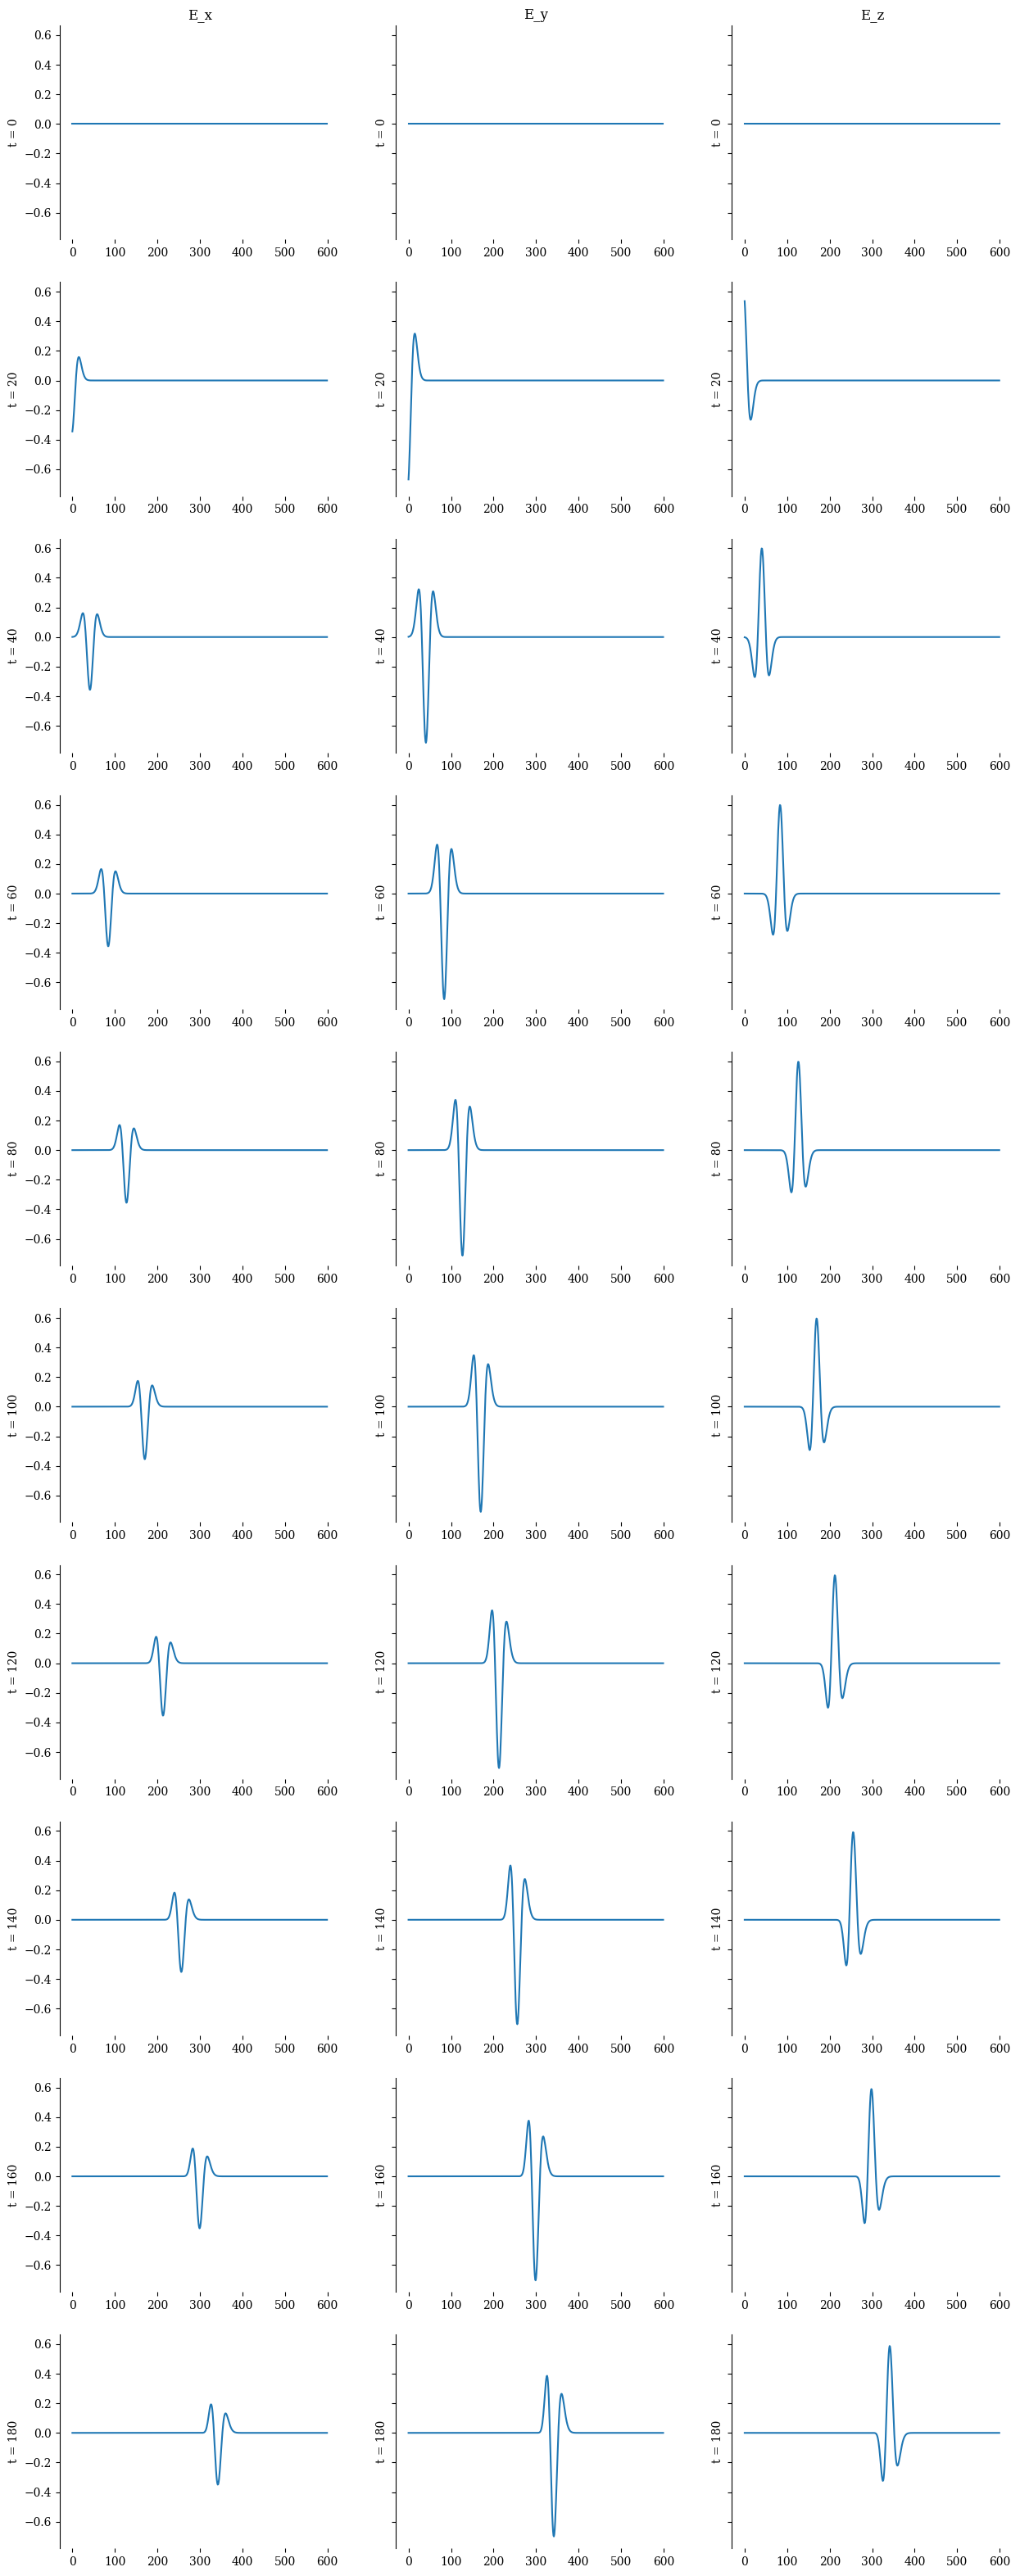

In [9]:
timeStep = 20
numberOfPlots = time_duration//timeStep
fig, axes = plt.subplots(numberOfPlots, 3, figsize=(15, 40), sharey=True)

for i in range(numberOfPlots):
    axes[i, 0].plot(DPW1.E_fields[0, :, i*timeStep])
    axes[i, 0].set_ylabel('t = {}'.format(i*timeStep), rotation='vertical')
    axes[i, 0].spines['top'].set_visible(False)
    axes[i, 0].spines['right'].set_visible(False)
    axes[i, 0].spines['bottom'].set_visible(False)
axes[0, 0].set_title("E_x")

for i in range(numberOfPlots):
    axes[i, 1].plot(DPW1.E_fields[1, :, i*timeStep])
    axes[i, 1].set_ylabel('t = {}'.format(i*timeStep), rotation='vertical')
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['bottom'].set_visible(False)
axes[0, 1].set_title("E_y")

for i in range(numberOfPlots):
    axes[i, 2].plot(DPW1.E_fields[2, :, i*timeStep])
    axes[i, 2].set_ylabel('t = {}'.format(i*timeStep), rotation='vertical')
    axes[i, 2].spines['top'].set_visible(False)
    axes[i, 2].spines['right'].set_visible(False)
    axes[i, 2].spines['bottom'].set_visible(False)
axes[0, 2].set_title("E_z")

plt.show()

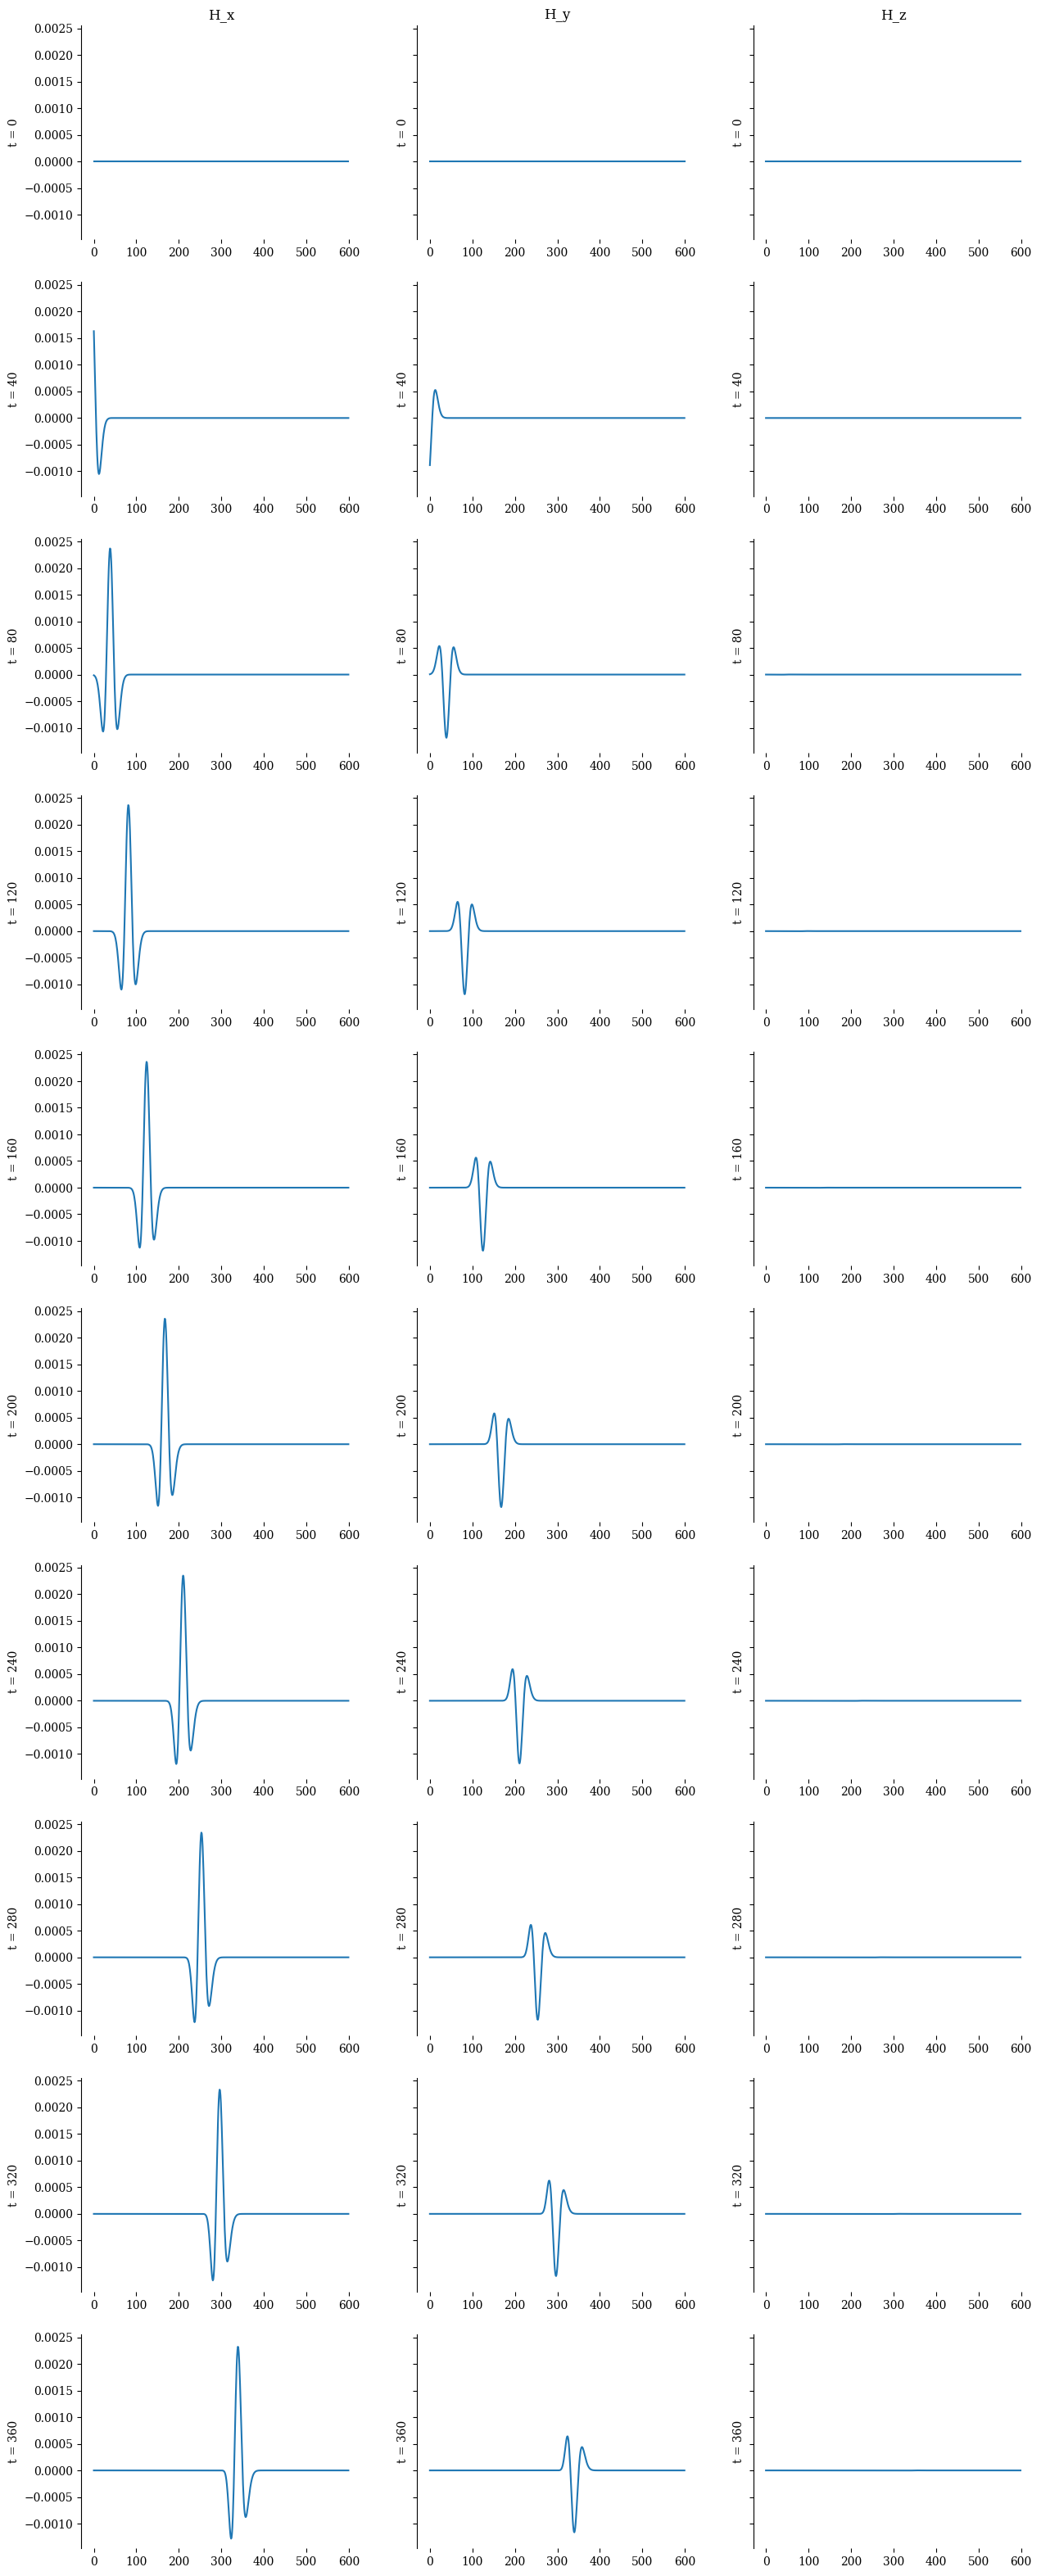

In [10]:
timeStep = 20
numberOfPlots = time_duration//timeStep
fig, axes = plt.subplots(numberOfPlots, 3, figsize=(15, 40), sharey=True)

for i in range(numberOfPlots):
    axes[i, 0].plot(H[0, :, i*timeStep])
    axes[i, 0].set_ylabel('t = {}'.format(i*40), rotation='vertical')
    axes[i, 0].spines['top'].set_visible(False)
    axes[i, 0].spines['right'].set_visible(False)
    axes[i, 0].spines['bottom'].set_visible(False)
axes[0, 0].set_title("H_x")

for i in range(numberOfPlots):
    axes[i, 1].plot(H[1, :, i*timeStep])
    axes[i, 1].set_ylabel('t = {}'.format(i*40), rotation='vertical')
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['bottom'].set_visible(False)
axes[0, 1].set_title("H_y")

for i in range(numberOfPlots):
    axes[i, 2].plot(H[2, :, i*timeStep])
    axes[i, 2].set_ylabel('t = {}'.format(i*40), rotation='vertical')
    axes[i, 2].spines['top'].set_visible(False)
    axes[i, 2].spines['right'].set_visible(False)
    axes[i, 2].spines['bottom'].set_visible(False)
axes[0, 2].set_title("H_z")

plt.show()

In [8]:
class TFSFBox():
    '''
    Class to implement a Total Field/Scattered Field(TFSF) implementation of the DPW described in
    Chapter 3: Exact Total-Field/Scattered-Field Plane-Wave Source Condition
    by Tengmeng Tan and Mike Potter
    of Steven Johnson; Ardavan Oskooi; Allen Taflove, Advances in FDTD Computational Electrodynamics: Photonics and Nanotechnology,
    Artech, 2013. (ISBN:9781608071715)
    __________________________
    
    Instance variables:
    --------------------------
        n_x, int            : stores the number of grid cells along the x axis of the TFSF box
        n_y, int            : stores the number of grid cells along the y axis of the TFSF box
        n_z, int            : stores the number of grid cells along the z axis of the TFSF box
        e_x, double array   : stores the x component of the electric field for the grid cells over the TFSF box
        e_y, double array   : stores the y component of the electric field for the grid cells over the TFSF box
        e_z, double array   : stores the z component of the electric field for the grid cells over the TFSF box
        h_x, double array   : stores the x component of the magnetic field for the grid cells over the TFSF box
        h_y, double array   : stores the y component of the magnetic field for the grid cells over the TFSF box
        h_z, double array   : stores the z component of the magnetic field for the grid cells over the TFSF box
        corners, int array  : stores the coordinates of the cornets of the total field/scattered field boundaries
        time_dimension, int : stores the time length over which the FDTD simulation is run
    '''
    def __init__(self, n_x, n_y, n_z, corners, time_duration):
        '''
        Defines the instance variables of class DiscretePlaneWave()
        __________________________
        
        Input parameters:
        --------------------------
            n_x, int            : stores the number of grid cells along the x axis of the TFSF box
            n_y, int            : stores the number of grid cells along the y axis of the TFSF box
            n_z, int            : stores the number of grid cells along the z axis of the TFSF box
            corners, int array  : stores the coordinates of the cornets of the total field/scattered field boundaries
            time_dimension, int : stores the time length over which the FDTD simulation is run
        '''
        self.n_x = n_x   #assign the instance varibales with the number of grid points along each axis
        self.n_y = n_y
        self.n_z = n_z
        #intitialise the 3D grids with n_x, n_y, n_z cells and +1 components where necessary    
        self.e_x = np.zeros((self.n_x, self.n_y+1, self.n_z+1))
        self.e_y = np.zeros((self.n_x+1, self.n_y, self.n_z+1))
        self.e_z = np.zeros((self.n_x+1, self.n_y+1, self.n_z))
        self.h_x = np.zeros((self.n_x+1, self.n_y, self.n_z))
        self.h_y = np.zeros((self.n_x, self.n_y+1, self.n_z))
        self.h_z = np.zeros((self.n_x, self.n_y, self.n_z+1))
        self.corners = corners
        self.time_duration = time_duration
    
    #@jit(nopython=True)
    def updateHFields(self, coefficients):
        for i in range(self.n_x):
            for j in range(self.n_y):
                for k in range(self.n_z):
                    self.h_x[i, j, k] = coefficients[0] * self.h_x[i, j, k] + coefficients[1] * (
                        self.e_y[i, j, k+1] - self.e_y[i, j, k]) - coefficients[2] * (
                        self.e_z[i, j+1, k] - self.e_z[i, j, k])

        for i in range(self.n_x):
            for j in range(self.n_y):
                for k in range(self.n_z):
                    self.h_y[i, j, k] = coefficients[3] * self.h_y[i, j, k] + coefficients[4] * (
                        self.e_z[i+1, j, k] - self.e_z[i, j, k]) - coefficients[5] * (
                        self.e_x[i, j, k+1] - self.e_x[i, j, k])

        for i in range(self.n_x):
            for j in range(self.n_y):
                for k in range(self.n_z):
                    self.h_z[i, j, k] = coefficients[6] * self.h_z[i, j, k] + coefficients[7] * (
                        self.e_x[i, j+1, k] - self.e_x[i, j, k]) - coefficients[8] * (
                        self.e_y[i+1, j, k] - self.e_y[i, j, k])


    #@jit(nopython=True)
    def updateEFields(self, coefficients):
        for i in range(self.n_x):
            for j in range(1, self.n_y):
                for k in range(1, self.n_z):
                    self.e_x[i, j, k] = coefficients[0] * self.e_x[i, j, k] + coefficients[1] * (
                        self.h_z[i, j, k] - self.h_z[i, j-1, k]) - coefficients[2] * (
                        self.h_y[i, j, k] - self.h_y[i, j, k-1])

        for i in range(1, self.n_x):
            for j in range(self.n_y):
                for k in range(1, self.n_z):
                    self.e_y[i, j, k] = coefficients[3] * self.e_y[i, j, k] + coefficients[4] * (
                        self.h_x[i, j, k] - self.h_x[i, j, k-1]) - coefficients[5] * (
                        self.h_z[i, j, k] - self.h_z[i-1, j, k])

        for i in range(1, self.n_x):
            for j in range(1, self.n_y):
                for k in range(self.n_z):
                    self.e_z[i, j, k] = coefficients[6] * self.e_z[i, j, k] + coefficients[7] * (
                        self.h_y[i, j, k] - self.h_y[i-1, j, k]) - coefficients[8] * (
                        self.h_x[i, j, k] - self.h_x[i, j-1, k])

    def initializeABC(self):
        # Allocate memory for ABC arrays
        eyx0 = np.zeros((self.n_y, self.n_z))
        ezx0 = np.zeros((self.n_y, self.n_z-1))
        eyx1 = np.zeros((self.n_y, self.n_z))
        ezx1 = np.zeros((self.n_y, self.n_z-1))

        exy0 = np.zeros((self.n_x, self.n_z))
        ezy0 = np.zeros((self.n_x, self.n_z-1))
        exy1 = np.zeros((self.n_x, self.n_z))
        ezy1 = np.zeros((self.n_x, self.n_z-1))

        exz0 = np.zeros((self.n_x, self.n_y))
        eyz0 = np.zeros((self.n_x, self.n_y-1))
        exz1 = np.zeros((self.n_x, self.n_y))
        eyz1 = np.zeros((self.n_x, self.n_y-1))

        abccoef = (1/np.sqrt(3.0)-1.0)/(1/np.sqrt(3.0)+1.0)

        return exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef
    
    #@jit(nopython=True)
    def implementABC(self, exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef):
        #implement ABC at x0
        for j in range(self.n_y-1):
            for k in range(self.n_z):
                self.e_y[0, j, k] = eyx0[j, k] + abccoef*(self.e_y[1, j, k] - self.e_y[0, j, k])
                eyx0[j, k] = self.e_y[1, j, k]
        for j in range(self.n_y):
            for k in range(self.n_z-1):
                self.e_z[0, j, k] = ezx0[j, k] + abccoef*(self.e_z[1, j, k] - self.e_z[0, j, k])
                ezx0[j, k] = self.e_z[1, j ,k]

        #implement ABC at x1
        for j in range(self.n_y-1):
            for k in range(self.n_z):
                self.e_y[-1, j, k] = eyx1[j, k] + abccoef*(self.e_y[-2, j, k] - self.e_y[-1, j, k])
                eyx1[j, k] = self.e_y[-2, j, k]
        for j in range(self.n_y):
            for k in range(self.n_z-1):
                self.e_z[-1, j, k] = ezx1[j, k] + abccoef*(self.e_z[-2, j, k] - self.e_z[-1, j, k])
                ezx1[j, k] = self.e_z[-2, j, k]

        #implement ABC at y0
        for i in range(self.n_x-1):
            for k in range(self.n_z):
                self.e_x[i, 0, k] = exy0[i, k] + abccoef*(self.e_x[i, 1, k] - self.e_x[i, 0, k])
                exy0[i, k] = self.e_x[i, 1, k]
        for i in range(self.n_x):
            for k in range(self.n_z-1):
                self.e_z[i, 0, k] = ezy0[i, k] + abccoef*(self.e_z[i, 1, k] - self.e_z[i, 0, k])
                ezy0[i, k] = self.e_z[i, 1, k]
        #implement ABC at y1
        for i in range(self.n_x-1):
            for k in range(self.n_z):
                self.e_x[i, -1, k] = exy1[i, k] + abccoef*(self.e_x[i, -2, k] - self.e_x[i, -1, k])
                exy1[i, k] = self.e_x[i, -2, k]
        for i in range(self.n_x):
            for k in range(self.n_z-1):
                self.e_z[i, -1, k] = ezy1[i, k] + abccoef*(self.e_z[i, -2, k] - self.e_z[i, -1, k])
                ezy1[i, k] = self.e_z[i, -2, k]

        #implement ABC at z0
        for i in range(self.n_x-1):
            for j in range(self.n_y):
                self.e_x[i, j, 0] = exz0[i, j] + abccoef*(self.e_x[i, j, 1] - self.e_x[i, j, 0])
                exz0[i, j] = self.e_x[i, j, 1]
        for i in range(self.n_x):
            for j in range(self.n_y-1):
                self.e_y[i, j, 0] = eyz0[i, j] + abccoef*(self.e_y[i, j, 1] - self.e_y[i, j, 0])
                eyz0[i, j] = self.e_z[i, j, 1]
        #implement ABC at z1
        for i in range(self.n_x-1):
            for j in range(self.n_y):
                self.e_x[i, j, -1] = exz1[i, j] + abccoef*(self.e_x[i, j, -2] - self.e_x[i, j, -1])
                exz1[i, j] = self.e_x[i, j, -2]
        for i in range(self.n_x):
            for j in range(self.n_y-1):
                self.e_y[i, j, -1] = eyz1[i, j] + abccoef*(self.e_y[i, j, -2] - self.e_y[i, j, -1])
                eyz1[i, j] = self.e_z[i, j, -2]

        return exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1
    
    #@jit(nopython=True)
    def applyTFSFMagnetic(self, coefficients, e1D, m, starting_point):

        #**** constant x faces -- scattered-field nodes ****
        i = self.corners[0]
        for j in range(self.corners[1], self.corners[4]+1):
            for k in range(self.corners[2], self.corners[5]):
                #correct Hy at firstX-1/2 by subtracting Ez_inc
                self.h_y[i-1, j, k] -= coefficients[5] * getField(i, j, k, e1D, m, 2, starting_point) 

        for j in range(self.corners[1], self.corners[4]):
            for k in range(self.corners[2], self.corners[5]+1):
                #correct Hz at firstX-1/2 by adding Ey_inc
                self.h_z[i-1, j, k] += coefficients[8] * getField(i, j, k, e1D, m, 1, starting_point)

        i = self.corners[3]
        for j in range(self.corners[1], self.corners[4]+1):
            for k in range(self.corners[2], self.corners[5]):
                #correct Hy at lastX+1/2 by adding Ez_inc
                self.h_y[i, j, k] += coefficients[5] * getField(i, j, k, e1D, m, 2, starting_point)    

        for j in range(self.corners[1], self.corners[4]):
            for k in range(self.corners[2], self.corners[5]+1):
                #correct Hz at lastX+1/2 by subtractinging Ey_inc
                self.h_z[i, j, k] -= coefficients[8] * getField(i, j, k, e1D, m, 1, starting_point)            

        #**** constant y faces -- scattered-field nodes ****
        j = self.corners[1]
        for i in range(self.corners[0], self.corners[3]+1):
            for k in range(self.corners[2], self.corners[5]):
                #correct Hx at firstY-1/2 by adding Ez_inc
                self.h_x[i, j-1, k] += coefficients[2] * getField(i, j, k, e1D, m, 2, starting_point)

        for i in range(self.corners[0], self.corners[3]):
            for k in range(self.corners[2], self.corners[5]+1):
                #correct Hz at firstY-1/2 by subtracting Ex_inc
                self.h_z[i, j-1, k] -= coefficients[7] * getField(i, j, k, e1D, m, 0, starting_point)

        j = self.corners[4]
        for i in range(self.corners[0], self.corners[3]+1):
            for k in range(self.corners[2], self.corners[5]):
                #correct Hx at lastY+1/2 by subtracting Ez_inc
                self.h_x[i, j, k] -= coefficients[2] * getField(i, j, k, e1D, m, 2, starting_point)

        for i in range(self.corners[0], self.corners[3]):
            for k in range(self.corners[2], self.corners[5]+1):
                #correct Hz at lastY-1/2 by adding Ex_inc
                self.h_z[i, j, k] += coefficients[7] * getField(i, j, k, e1D, m, 0, starting_point)

        #**** constant z faces -- scattered-field nodes ****
        k = self.corners[2]
        for i in range(self.corners[0], self.corners[3]):
            for j in range(self.corners[1], self.corners[4]+1):
                #correct Hy at firstZ-1/2 by adding Ex_inc
                self.h_y[i, j, k-1] += coefficients[5] * getField(i, j, k, e1D, m, 0, starting_point)

        for i in range(self.corners[0], self.corners[3]+1):
            for j in range(self.corners[1], self.corners[4]):
                #correct Hx at firstZ-1/2 by subtracting Ey_inc
                self.h_x[i, j, k-1] -= coefficients[1] * getField(i, j, k, e1D, m, 1, starting_point)

        k = self.corners[5]
        for i in range(self.corners[0], self.corners[3]):
            for j in range(self.corners[1], self.corners[4]+1):
                #correct Hy at firstZ-1/2 by subtracting Ex_inc
                self.h_y[i, j, k] -= coefficients[5] * getField(i, j, k, e1D, m, 0, starting_point)

        for i in range(self.corners[0], self.corners[3]+1):
            for j in range(self.corners[1], self.corners[4]):
                #correct Hx at lastZ+1/2 by adding Ey_inc
                self.h_x[i, j, k] += coefficients[1] * getField(i, j, k, e1D, m, 1, starting_point)

    
    #@jit(nopython=True)
    def applyTFSFElectric(self, coefficients, h1D, m, starting_point):
        #**** constant x faces -- total-field nodes ****/
        i = self.corners[0]
        for j in range(self.corners[1], self.corners[4]+1):
            for k in range(self.corners[2], self.corners[5]):
                #correct Ez at firstX face by subtracting Hy_inc
                self.e_z[i, j, k] -= coefficients[7] * getField(i-1, j, k, h1D, m, 1, starting_point)

        for j in range(self.corners[1], self.corners[4]):
            for k in range(self.corners[2], self.corners[5]+1):
                #correct Ey at firstX face by adding Hz_inc
                self.e_y[i, j, k] += coefficients[4] * getField(i-1, j, k, h1D, m, 2, starting_point)

        i = self.corners[3]
        for j in range(self.corners[1], self.corners[4]+1):
            for k in range(self.corners[2], self.corners[5]):
                #correct Ez at lastX face by adding Hy_inc
                self.e_z[i, j, k] += coefficients[7] * getField(i, j, k, h1D, m, 1, starting_point)

        i = self.corners[3]
        for j in range(self.corners[1], self.corners[4]):
            for k in range(self.corners[2], self.corners[5]+1):
                #correct Ey at lastX face by subtracting Hz_inc
                self.e_y[i, j, k] -= coefficients[4] * getField(i, j, k, h1D, m, 2, starting_point)

        #**** constant y faces -- total-field nodes ****/
        j = self.corners[1]
        for i in range(self.corners[0], self.corners[3]+1):
            for k in range(self.corners[2], self.corners[5]):
                #correct Ez at firstY face by adding Hx_inc
                self.e_z[i, j, k] += coefficients[8] * getField(i, j-1, k, h1D, m, 0, starting_point)

        for i in range(self.corners[0], self.corners[3]):
            for k in range(self.corners[2], self.corners[5]+1):
                #correct Ex at firstY face by subtracting Hz_inc
                self.e_x[i, j, k] -= coefficients[1] * getField(i, j-1, k, h1D, m, 2, starting_point)

        j = self.corners[4]
        for i in range(self.corners[0], self.corners[3]+1):
            for k in range(self.corners[2], self.corners[5]):
                #correct Ez at lastY face by subtracting Hx_inc
                self.e_z[i, j, k] -= coefficients[8] * getField(i, j, k, h1D, m, 0, starting_point)

        for i in range(self.corners[0], self.corners[3]):
            for k in range(self.corners[2], self.corners[5]+1):
                #correct Ex at lastY face by adding Hz_inc
                self.e_x[i, j, k] += coefficients[1] * getField(i, j, k, h1D, m, 2, starting_point)

        #**** constant z faces -- total-field nodes ****/
        k = self.corners[2]
        for i in range(self.corners[0], self.corners[3]+1):
            for j in range(self.corners[1], self.corners[4]):
                #correct Ey at firstZ face by subtracting Hx_inc
                self.e_y[i, j, k] -= coefficients[4] * getField(i, j, k-1, h1D, m, 0, starting_point)

        for i in range(self.corners[0], self.corners[3]):
            for j in range(self.corners[1], self.corners[4]+1):
                #correct Ex at firstZ face by adding Hy_inc
                self.e_x[i, j, k] += coefficients[2] * getField(i, j, k-1, h1D, m, 1, starting_point)

        k = self.corners[5]
        for i in range(self.corners[0], self.corners[3]+1):
            for j in range(self.corners[1], self.corners[4]):
                #correct Ey at lastZ face by adding Hx_inc
                self.e_y[i, j, k] += coefficients[4] * getField(i, j, k, h1D, m, 0, starting_point)

        for i in range(self.corners[0], self.corners[3]):
            for j in range(self.corners[1], self.corners[4]+1):
                #correct Ex at lastZ face by subtracting Hy_inc
                self.e_x[i, j, k] -= coefficients[2] * getField(i, j, k, h1D, m, 1, starting_point)
        
    def getFields(self, E, H, C, D, m, snapshot, starting_point):
        exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef = self.initializeABC()
        #E and H are the one-dimensional waves
        for i in range(self.time_duration):
            self.updateHFields(D)
            self.applyTFSFMagnetic(D, E[:, :, i-1], m, starting_point)
            self.applyTFSFElectric(C, H[:, :, i], m, starting_point)
            self.updateEFields(C)    

            exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1 = self.implementABC(
                            exy0, exy1, exz0, exz1, eyx0, eyx1, eyz0, eyz1, ezx0, ezx1, ezy0, ezy1, abccoef)
            if (i % snapshot == 0):
                takeSnapshot3D(self.e_x, i)

In [9]:
def getField(i, j, k, array, m, component, starting_point):
        buffer = 10
        return array[component, np.dot(m[:-1], np.abs(np.array([i, j, k])-starting_point))]
    
def takeSnapshot3D(e_z, number):
    np.save('./snapshots/electric_z_{}.npy'.format(number), e_z)
    #np.save('./snapshots/electric_y_{}.npy'.format(number), e_y)

In [13]:
start = time.time()

time_duration = 100
#start_point = np.array([number_x, number_y, number_z])
start_point = np.array([0, 0, 0])

SpaceGrid = TFSFBox(number_x, number_y, number_z, corners, time_duration)
SpaceGrid.getFields(DPW1.E_fields, DPW1.H_fields, C, D, DPW1.m, snapshot, start_point)
        
end = time.time()
print("Elapsed (with compilation) = %s sec" % (end - start))

Elapsed (with compilation) = 25.421563863754272 sec


In [14]:
fields = np.zeros((number_x, number_y+1, number_z+1, time_duration//snapshot))
for i in range(time_duration//snapshot):
    fields[:, :, :, i] = np.load('./snapshots/electric_z_{}.npy'.format(i*snapshot), allow_pickle=True)

In [79]:
print(fields.shape)

(25, 26, 26, 10)


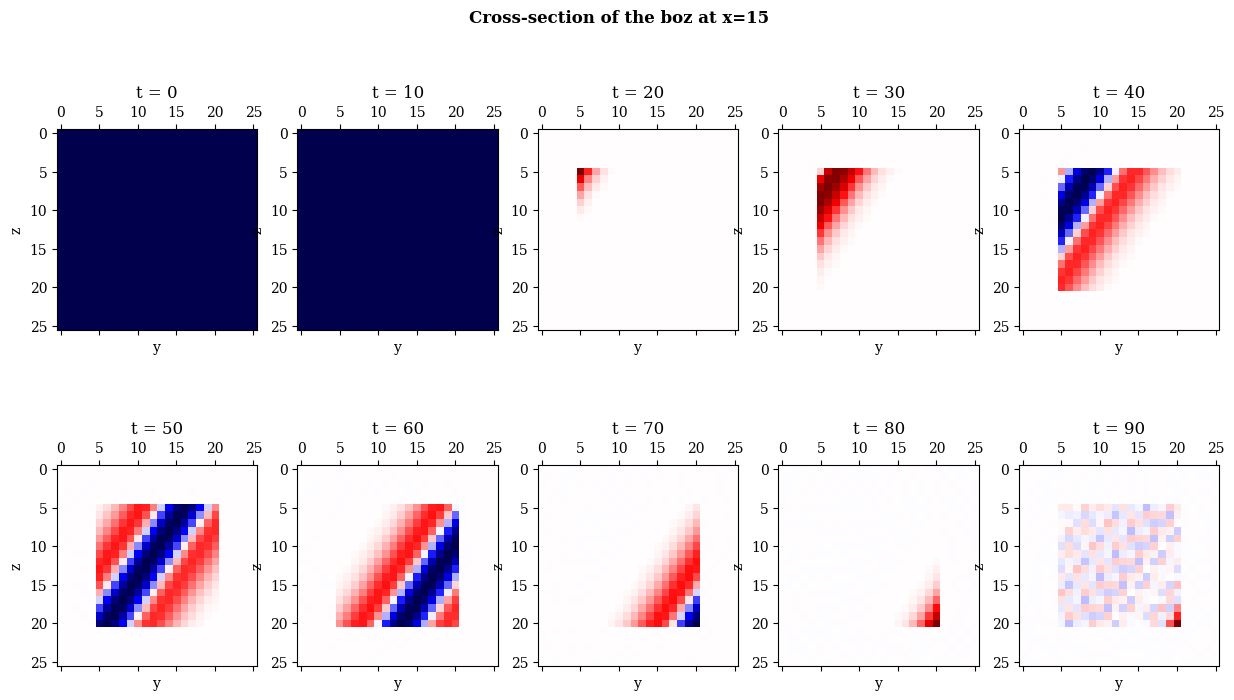

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[5, :, :, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('y')
        axes[i, j].set_ylabel('z')        

fig.suptitle('Cross-section of the boz at x=15', fontweight='bold')
plt.show()

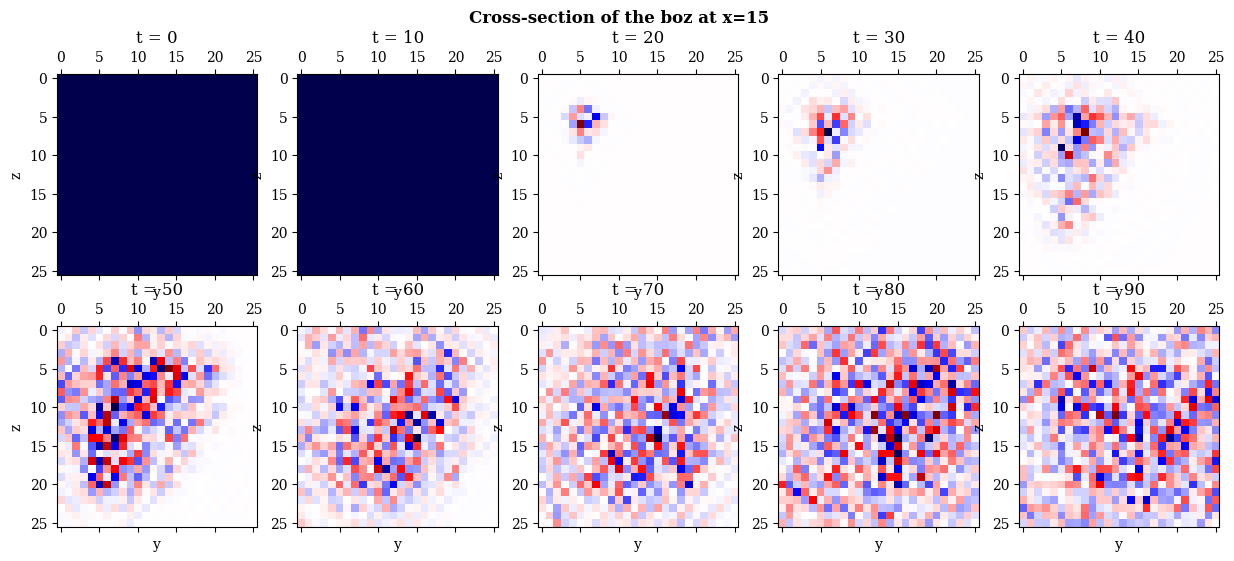

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[4, :, :, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('y')
        axes[i, j].set_ylabel('z')        

fig.suptitle('Cross-section of the boz at x=15', fontweight='bold')
#plt.savefig('./crossSectionX.png')
plt.show()

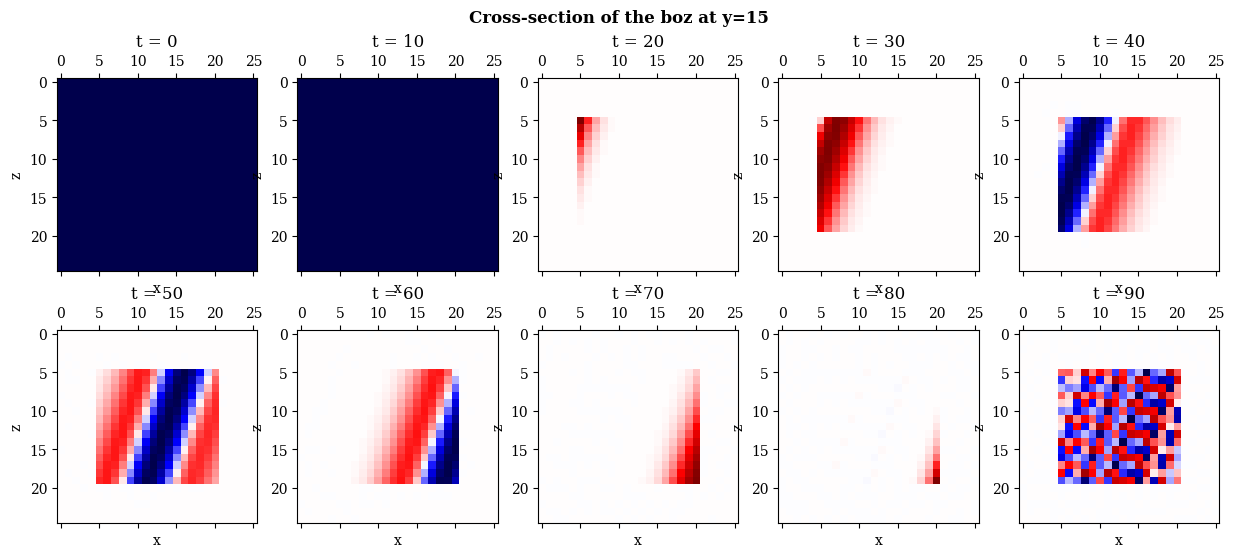

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[:, 5, :, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('x')
        axes[i, j].set_ylabel('z')        

fig.suptitle('Cross-section of the boz at y=15', fontweight='bold')
#plt.savefig('./crossSectionY.png')
plt.show()

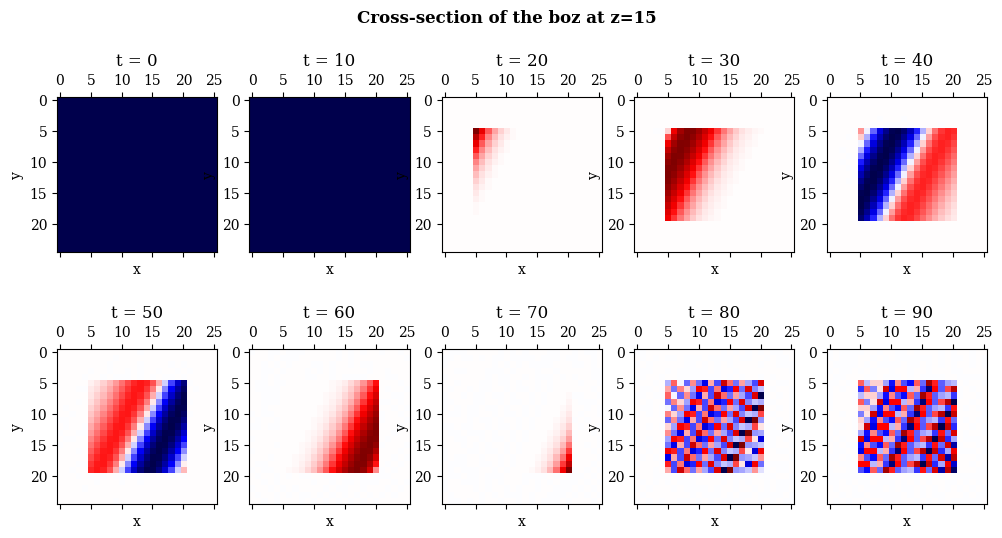

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(2):
    for j in range(5):
        axes[i, j].matshow(fields[:, :, 5, i*5+j], cmap=mpl.colormaps['seismic'], norm=mpl.colors.CenteredNorm())
        axes[i, j].set_title('t = {}'.format((i*5+j)*10))
        axes[i, j].set_xlabel('x')
        axes[i, j].set_ylabel('y')        

fig.suptitle('Cross-section of the boz at z=15', fontweight='bold')
#plt.savefig('./crossSectionZ.png')
plt.show()